In [1]:
import hopsworks
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
2024-05-28 12:33:41,666 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-05-28 12:33:41,666 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
try: 
    feature_view = fs.get_feature_view(name="spot59", version=1)
except:
    fg = fs.get_feature_group(name="spot59", version=1)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="spot59",
                                      version=1,
                                      description="sensor 59",
                                      query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/549021/fs/544844/fv/spot59/version/1


In [3]:
feature, labels = feature_view.training_data(
    description = 'spot59 training dataset',
)

features = feature[['x','y','z','temperature','magnitude']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.78s) 
2024-05-28 12:33:53,804 WARNING: VersionWarning: Incremented version to `1`.



2024-05-28 12:33:55,861 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-05-28 12:33:56,043 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



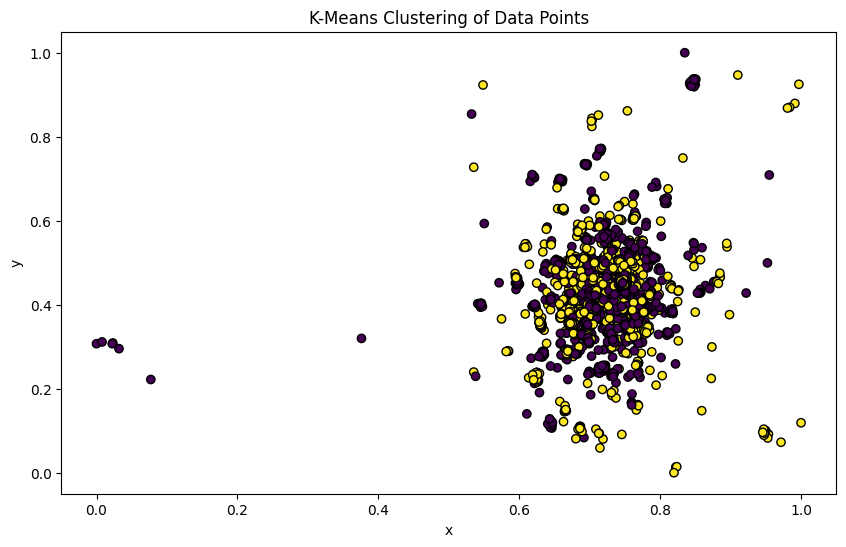

          x         y         z  temperature  magnitude  cluster
0  0.746497  0.362025  0.369391     0.571429   0.908169        0
1  0.846760  0.936709  0.362981     0.530612   1.313842        0
2  0.721979  0.589030  0.304487     0.816327   0.980266        0
3  0.745184  0.447257  0.286058     0.510204   0.914968        0
4  0.703152  0.448945  0.264423     0.673469   0.875154        0


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

kmeans = KMeans(n_clusters=2, random_state=42)  

kmeans.fit(features)

clusters = kmeans.predict(features)

features['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(features['x'], features['y'], c=features['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of Data Points')
plt.show()

print(features.head())

cluster_counts = features['cluster'].value_counts()
anomaly_cluster = cluster_counts.idxmin()

anomalies = features[features['cluster'] == anomaly_cluster]

anomaly_indices = anomalies.index

In [5]:
features.head(20)

,x,y,z,temperature,magnitude,cluster
0,0.746497,0.362025,0.369391,0.571429,0.908169,0
1,0.846760,0.936709,0.362981,0.530612,1.313842,0
2,0.721979,0.589030,0.304487,0.816327,0.980266,0
3,0.745184,0.447257,0.286058,0.510204,0.914968,0
4,0.703152,0.448945,0.264423,0.673469,0.875154,0
5,0.750000,0.445570,0.283654,0.265306,0.917329,1
6,0.574869,0.366245,0.179487,0.306122,0.704858,1
7,0.742995,0.454008,0.254006,0.265306,0.907019,1
8,0.748687,0.475949,0.275641,0.122449,0.928998,1
9,0.746935,0.446414,0.278045,0.530612,0.913513,0


In [6]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import shutil

In [7]:
mr = project.get_model_registry()

model_dir1="spot59_k_nn"
if os.path.isdir(model_dir1) == False:
    os.mkdir(model_dir1)
joblib.dump(kmeans, model_dir1 + "/spot59_k_nn.pkl")



spot59 = mr.python.create_model(
    version=1,
    name="spot59_k_nn", 
    description="Anomaly detection- UML")

spot59.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/32999 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot59_k_nn/1


Model(name: 'spot59_k_nn', version: 1)